Neural Networks, also commonly known as “neural nets”, are a machine learning classifier based on the structure of the brain and neuron activations. They can be used for two-class or multiclass classification and are extremely flexible algorithms that can learn nonlinear decision boundaries, a huge advantage over many other algorithms. An example of a neural network that will be shown in this tutorial is predicting the digit that is in a picture of an image, which is a 10 class classification problem. 

Neural nets can be modified to have different numbers of hidden layers, with different numbers of nodes at each layer. Each layer in the model ends up getting matched to different features of the input. This is what gives the classifier its flexibility, since there are an infinite amount of combinations of hidden layers and nodes at each layer. However, the training process for the algorithm increases exponentially as the number of hidden layers and number of nodes at each layer increases, and this is usually taken into account when choosing the number of hidden layers in the network. A picture of a neural net with one hidden layer and two predicted classes is shown below. 

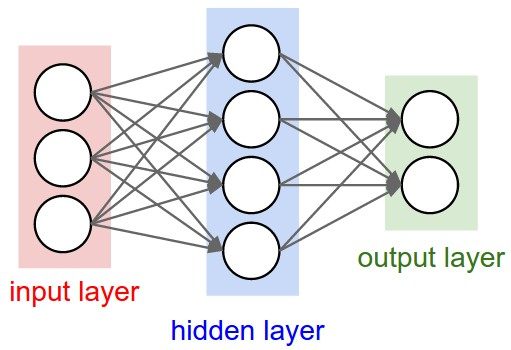

In [3]:
# Image of a neural network

from IPython.display import Image
Image('neuralnet.jpeg')


The simplest version of a neural network is a perceptron. A perceptron does not have any hidden layers, it only has an input and output layer, with weights for each path from each input node to the output node. A perceptron is a linear binary classifier, meaning that it only works for two-class classification and it can only learn a linear decision boundary, unlike a neural network. The general structure of a perceptron is shown in the image below. 

The input to the perceptron is a numeric feature vector, meaning that categorical variables need to be recoded to numeric values. The input vector is shown in the image as $1,x_1,x_2,...x_m$. The output values of interest can either be the probability that each observation is in each class or just the predicted class of the observation. The input vector is multiplied by the respective weight of its path to the output node, shown in the image as $w_0,w_1,w_2,...w_m$, and the value of the output node is the sum of all of these values with an added bias term ($\sum_{i=1}^{m} w_{i}x_i + b $). A nonliear smoothing function can also be applied at this point, shown by the activation function node in the image below. The predicted class is determined by whether the value of the output at this point is positive or negative, which is why the classifier only works for two-class classification. A perceptron is extended to a neural network model (multilayer perceptron) by adding hidden layers between the input and the output layer and having more than one output node. 

The final part of the perceptron model is training the model using the error. The error we will use is defined by the negative log likelihood function, $-\sum_{i=0}^{m} log (P(Y=y^{(i)}\vert x^{(i)},W,b))$. Where $P(Y=y^{(i)}\vert x^{(i)},W,b)$ is defined by $softmax_i(Wx+b) = \frac{e^{w_ix+b_i}}{\sum_{j}e^{w_jx+b_j}}$. This log likelihood function tries to maximize the probability that the observation is in the correct predicted class. We use gradient descent to update the parameters (weights and biases), using the gradient of the loss function (negative log likelihood) with respect to every parameter in the model and a method called backpropagation. Luckily, Theano does these calculations for us using a simple function call. Once the training has finished, we can predict the class of new input values. 


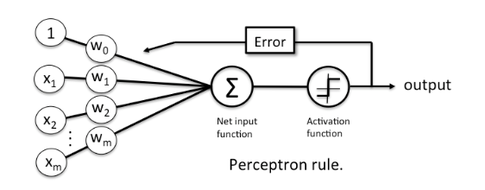

In [5]:
Image('perceptron.png')

To implement a neural network, we will be using the Theano package in python. The package can be installed using pip, using the following command. This install will also install the dependencies needed for Theano, such as NumPy and SciPy. 

$ pip install theano

The main frame work for a multi-layer neural network in Theano is a Logistic Regression classifier. The Logistic Regression classifier follows the pattern for the perceptron, however is extended to be able to have more than one output node and therefore can be used for multiclass classification. The weights for the layer can be initialized to zero or as uniform values from a distribution defined by the acivation function used. We will be using the sigmoid function, so we will use the interval $[-4\sqrt(\frac{6}{n_{in}+n_{out}}),4\sqrt(\frac{6}{n_{in}+n_{out}})]$ to draw random weights from. We will define a Logistic Regression class to encapsulate this layer. The class will include the initialization of weights, storing them as attributes of the class, attributes for the probability of each class given each input and for the predicted class for each input, and methods for the negative log likelihood function and for calculating the errors of our current model. The probability of each class given the input is defined by the softmax function as stated above and the predicted class is determined by taking the argmax of the softmax function. 


Theano variables that need to be changed or used between functions need to be set as shared thano variables. We do this for the weights for each layer and later for the training and testing values we import. 

In [5]:
from __future__ import print_function

import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T

from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
# creating the Logistic Regression class
# Code taken from http://deeplearning.net/tutorial/logreg.html


class LogisticRegression(object):

    # initialize the instance of the class
    def __init__(self, rng, input, n_in, n_out):


        # initialize the weights for the layer by randomly selecting values from the interval mentioned above
        W_values = numpy.asarray(rng.uniform(
                low=-4*numpy.sqrt(6. / (n_in + n_out)),
                high=4*numpy.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)),
            dtype=theano.config.floatX)

        # set the weights to be shared variables
        self.W = theano.shared(value=W_values, name="W3", borrow=True)
    
        # initialize the biases to zeros and set them as shared variables
        self.b = theano.shared(value=numpy.zeros((n_out,), dtype=theano.config.floatX),
            name="b3", borrow=True)

        # compute the probability of each class given the features using the softmax function
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # find the predicted class using the argmax function on the probabilities of each 
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # set a params attribute that has the weights and the biases for the layer
        self.params = [self.W, self.b]

        # set an attribute for the inputs of the layer
        self.input = input

    # create a method for the negative log likelihood function
    def neg_log_likelihood(self, y):

        # compute the negative log likelihood
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])


    # create a method that returns a list of boolean values for whether or not the prediction is correct
    def wrong_preds(self, y):
        return T.neq(self.y_pred, y)


    # create an error method that returns the error rate
    def errors(self, y):

        if y.ndim != self.y_pred.ndim:
            raise TypeError("y and y_pred do not have the same shape", 
                ("y", y.type, "y_pred", self.y_pred.type))

        if y.dtype.startswith("int"):
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()



The Logistic Regression class serves as the output layer when we extend the framework to a multi-layer perceptron, or neural network. We also need to include hidden layers when we extend to doing neural networks, for which we will create another class. Hidden layers are layers of nodes in between the input layer and the output layer, as seen in the first picture. Having multiple hidden layers in a neural net is referred to as "deep learning", which is a whole other area of machine learning that can be studied. 

The hidden layer class is not very complex, the main two components being initializing the weights and computing the output. The class takes as input a random number generator, the length of the input to the layer, the length of the output of the layer, the layer number (for keeping track of which parameters we are using), and an activation function. The weights are initialized the same way they were for the Logistic Regression layer, using zeros or random values from some interval. In this example, we use the interval corresponding to the sigmoid function again. The biases again are initialized to zero. For computing the output, if we are not using an activation (nonlinear) function, then we just return $Wx + b$ where $W$ is the weight matrix, $x$ is the input, and $b$ is the bias vector. If there is an activation function we return $function(Wx+b)$. We also once again maintain an attribute of the parameters, the weights and biases, of the layer. 

In [7]:
# create the hidden layer class
# code taken from Emily Helfer for 10-401 homework

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, layer, W=None, b=None, activation=T.nnet.sigmoid):

        # set input attribute
        self.input = input

        # if the weights aren't speficied, initialize them according to the correct interval 
        if W is None:
            W_values = numpy.asarray(rng.uniform(
                low=-4*numpy.sqrt(6. / (n_in + n_out)),
                high=4*numpy.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)),
            dtype=theano.config.floatX)

        # set the weights as a shared theano variable
        W = theano.shared(value=W_values, name="W"+str(layer), borrow=True)

        # if the biases aren't specified, initialize them to zero and set to shared variable
        if b is None: 
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name="b"+str(layer), borrow=True)

        # set the W and b attributes to be the weights and biases
        self.W = W
        self.b = b

        # take the product Wx + b
        lin_output = T.dot(input, self.W) + self.b
        # if there is an activation function return function(Wx+b) else just return Wx+b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
            )

        # set the parameter attribute to the weights and the biases of the layer
        self.params = [self.W, self.b]



Now that we have the two components of the model, the output layer and the hidden layers, we can combine them to make our neural network model. We can define a class called NN (for neural network) that combines the Logistic Regression class, the Hidden Layer class, and the attributes from the Logistic Regression class. The number of hidden layers is defined by the number of instances of the Hidden Layer class we create in our model. In this example we are using two hidden layers. We will only ever have one instance of the Logistic Regression class, since we only will have one output layer. 

The NN class takes as input a random number generator (rng), an input matrix (input), the number of nodes in the input layer (n_in), a list of the number of nodes in each input layer (n_hidden), and the number of classes we are trying to predict (n_out). The order of the layers of the network are determined by the ordering of n_in, n_hidden, and n_out and by using the output of the previous layer as the input to the next one. 

In [8]:
# create the neural network class

class NN(object):
    
    
    def __init__(self, rng, input, n_in, n_hidden, n_out):

        # first hidden layer in the model
        self.hiddenlayer1 = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden[0],
            layer = 1,
            activation = T.nnet.sigmoid)

        
        # second hidden layer in the model
        self.hiddenlayer2 = HiddenLayer(
            rng=rng,
            input=self.hiddenlayer1.output,
            n_in=n_hidden[0],
            n_out=n_hidden[1],
            layer = 2,
            activation=T.nnet.sigmoid)

        # set the logistic regression layer 
        self.logRegressionLayer = LogisticRegression(
            rng=rng,
            input=self.hiddenlayer2.output,
            n_in=n_hidden[1],
            n_out=n_out)

        # set the negative log likelihood to be the negative log likelihood from the LR layer
        self.neg_log_likelihood = (
            self.logRegressionLayer.neg_log_likelihood
            )

        # set the errors to be the errors from the LR layer
        self.errors = self.logRegressionLayer.errors

        # set the predicted values to be the predicted values from the LR layer
        self.y_pred = self.logRegressionLayer.y_pred

        # set the list of booleans to be the list from the LR layer
        self.wrong_preds = self.logRegressionLayer.wrong_preds

        # set the parameters of the model to be a tuple of the parameters from all of the layers
        self.params = (self.hiddenlayer1.params + self.hiddenlayer2.params 
                    + self.logRegressionLayer.params)

        self.input = input



Now that we have our model, we can apply it to a problem. For this example, we will be using the MNIST data set. The input for a single observation is a vector of length (28*28) where each value represents a pixel intensity. We are trying to predict the digit in the image, and so there are 10 classes (digits from 0-9). Example images are shown in the image below. 

To load the training and testing data, we will use readlines() with a simple for loop to add each line to a training or testing matrix, respectively.  

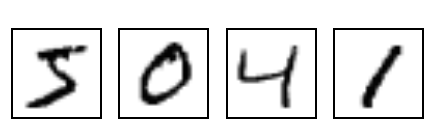

In [4]:
# example of mnist data
Image('mnist.png')

In [12]:
# load in the data for training and testing

reader_train = open("mnist_train.txt", "r")
lines_train = reader_train.readlines()  
matrix_train = []
for line in lines_train: 
    row = line.split(" ")
    row = map(float, row)
    matrix_train.append(row)
reader_train.close()


reader_test = open("mnist_test.txt", "r")
lines_test = reader_test.readlines()  
matrix_test = []
for line in lines_test: 
    row = line.split(" ")
    row = map(float, row)
    matrix_test.append(row)
reader_test.close()

For training and testing the model, we will create a function wrapper called train_nn. Within this function we will initialize the neural network class, write training and testing functions, and then call these functions appropriately. This is also where we define the updates for the weights using the gradients of the loss function. Once again Theano easily takes the gradients for us by calling T.grad on the loss function with respect to each of the parameters (weights and biases). We then use this to update the parameters by (param = param - learning_rate*gradient). These updates will happen during the training process of the neural network, and the finalized weights and biases will be used in the testing process to predict the classes for our new input. We will then return the list of predicted classes from the function. 

In [10]:
# function for training and testing the neural network

def train_nn(learning_rate = .13, train=matrix_train, test=matrix_test, n_hidden=[500,150]):


    # setting the training set to be a shared theano variable
    train_set_x = theano.shared(numpy.asarray([blah[1:] for blah in train],
                                            dtype=theano.config.floatX), borrow=True)
    train_set_y = T.cast(theano.shared(numpy.asarray([blah[0] for blah in train],
                                            dtype=theano.config.floatX), borrow=True),
                                            "int32")

    # setting the test set to be a shared theano variable
    test_set_x = theano.shared(numpy.asarray([blah2[1:] for blah2 in test],
                                            dtype=theano.config.floatX), borrow=True)
    test_set_y = T.cast(theano.shared(numpy.asarray([blah3[0] for blah3 in test],
                                            dtype=theano.config.floatX), borrow=True),
                                            "int32")


    print("build the model")

    # create the theano variables x and y
    x = T.matrix('x')
    y = T.ivector('y')

    # initialize the random number generator with a seed so we get the same results every time
    rng = numpy.random.RandomState(123)


    # initialize the classifier
    # the value of n_in is 28*28 since the images are of size 28*28
    # n_out is the number of classes which in this case is the number of digits which is 10
    classifier = NN(
        rng=rng,
        input=x,
        n_in=28*28,
        n_hidden=n_hidden,
        n_out=10)


    # set the cost to be the negative log likelihood function, the value which we want to minimize 
    cost = classifier.neg_log_likelihood(y)


    # write a function for testing the model 
    test_model = theano.function(
        inputs=[],
        outputs=classifier.y_pred,
        givens = {
            x: test_set_x,
        })


    # find the gradient of the cost function in terms of every parameter in the model
    # to use for gradient descent updates
    gparams = [T.grad(cost, param) for param in classifier.params]


    # update the parameters as appropriate according to gradient descent
    updates = [
        (param, param-learning_rate * gparam) 
        for param, gparam in zip(classifier.params, gparams)]


    # write a function for training the model, using the cost and updates 
    train_model = theano.function(
        inputs=[],
        outputs=cost,
        updates=updates,
        givens = {
            x: train_set_x,
            y: train_set_y
        })

    # train the model
    print("training the model")

    training_model = train_model()


    print("testing the model")
    # predict values on entire test set 
    test_predict = test_model()
    return test_predict

In [13]:
# run the train_nn function
predicted = train_nn()
# print the first 10 predictions
print(predicted[:10])

build the model
training the model
testing the model
[5 6 2 6 2 5 6 6 1 6]


This prints out the first 10 predictions from the testing set that were predicted from the model trained on our MNIST training data. 

For this example, I arbitrarily chose a number of hidden layers, numbers of nodes at each hidden layer, and a learning rate. This problem can be extended to also choose these parameters using grid search and finding the lowest error on a validation data set. The parameters found by the grid search algorithm can then be used for the model. 

Neural networks are a very flexible machine learning classifier that are able to be applied to many different problems. Predicting the digit in an image is a fairly simple task compared to others that can be done with neural networks, especially when you think about how The Terminator was trained on one ;). 